In [1]:
# Dependencies
import numpy as np
import os
import time 
import tensorflow as tf
from tqdm import tqdm
from google.colab import drive

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# Keras Dependencies
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization, Input
from keras.optimizers import Adam

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# import mnist dataset from keras
(TrainImages,TrainLabel),(_,_) = mnist.load_data()

TrainImages = TrainImages.reshape(TrainImages.shape[0], 28, 28, 1)
Indexes = np.where(TrainLabel == 5)
TrainImages = TrainImages[Indexes]

In [48]:
class DCGAN():
  
  def __init__(self,config = None):
    # Input Shape
    self.ImgHeight = 28 
    self.ImgWidth = 28
    self.ImgChannels = 1
    self.ImgShape = (self.ImgHeight, self.ImgWidth, self.ImgChannels)
    
    
    # Base Feature Maps Generator and Discriminator
    self.GenFMaps = 256 # must be divisible by 4
    self.DisFMaps = 64

    # Hyperparameters
    self.Dropout = 0.3
    self.Epochs = 10
    self.BatchSize = 256
    self.GDimension = 7 # Generator latent dimension
    self.LatentDim = 100

    # Visualization Parameters
    self.SampleInterval = 1
    self.ControlSizeSQRT = 6
    self.SavePath = '/content/drive/My Drive/GeneratedImages' #None
    self.ImagesSavedCount = 0
    self.Generator = None
    self.Discriminator = None
    self.Optimizer = tf.keras.optimizers.Adam(1e-4)
    self.DiscLosses = []
    self.GenLosses = []

    # Helper Function for Loss Calculation
    self.CrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Create Generator and Discriminator Models
    self.Generator = self.CreateGenerator()
    self.Discriminator = self.CreateDiscriminator() 

    # Define Optimizer
    self.GenOptimizer = Adam(0.0001)
    self.DiscOptimizer = Adam(0.0001)
    

  def CreateDiscriminator(self):
    if self.Discriminator:
      return self.Discriminator
    self.Discriminator = Sequential(name="Discriminator")
    
    self.Discriminator.add(Conv2D(self.DisFMaps, (5, 5),
                                  strides=(2, 2), padding="same",
                                  input_shape = self.ImgShape))
    self.Discriminator.add(LeakyReLU())
    self.Discriminator.add(Dropout(self.Dropout))

    self.Discriminator.add(Conv2D(2 * self.DisFMaps, (5, 5),
                                  strides=(2, 2), padding="same"))
    self.Discriminator.add(LeakyReLU())
    self.Discriminator.add(Dropout(self.Dropout))

    self.Discriminator.add(Flatten())
    self.Discriminator.add(Dense(1))
    
    return self.Discriminator

  
  def CreateGenerator(self):
    if self.Generator:
      return self.Generator
    
    self.Generator = Sequential(name="Generator")
    self.Generator.add(Dense(self.GDimension * self.GDimension * self.GenFMaps,
                             input_shape=(self.LatentDim,)))
    
    self.Generator.add(BatchNormalization())
    self.Generator.add(LeakyReLU())
    self.Generator.add(Reshape((self.GDimension, self.GDimension, self.GenFMaps)))
    self.Generator.add(Conv2DTranspose(self.GenFMaps / 2, 5, strides = 1,
                                  padding = "same"))
    
    self.Generator.add(BatchNormalization())
    self.Generator.add(LeakyReLU(alpha = 0.2))
    self.Generator.add(Conv2DTranspose(self.GenFMaps / 4, 5, strides = 2,
                                  padding = "same"))
    
    self.Generator.add(BatchNormalization())
    self.Generator.add(LeakyReLU(alpha = 0.2))

    self.Generator.add(Conv2DTranspose(1, 5, strides = 2,
                                  padding = "same", activation = "tanh"))
    assert self.Generator.output_shape == (None, 28, 28, 1)
    return self.Generator

  def CrossEntropy(self, TrueLabels, PredLabels, Logit = True):
    """
    Keras Sigmoidal Binary Crossentropy (Stable)
    Reference: https://medium.com/@rafayak/how-do-tensorflow-and-keras-implement-binary-classification-and-the-binary-cross-entropy-function-e9413826da7
    """
    if Logit:
      Z = PredLabels
    else:
      P = tf.clip_by_value(PredLabels,10**-7,0.999999)
      Z = tf.math.log(P/(1-P))
    Error = tf.reduce_mean(tf.math.maximum(tf.zeros_like(Z),Z) - TrueLabels* Z + 
                           tf.math.log(1 + tf.math.exp(-tf.math.abs(Z))))
    return Error


  # Loss Functions
  def BoundaryLoss(self, TrueLabels, PredLabels):
    """
    Boundary seeking loss. Custom loss based on Reference.
    Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/
    """
    Error = 0.5 * tf.reduce_mean(tf.square(tf.math.log(PredLabels)-tf.math.log(1 - PredLabels)))
    return Error

  def WassersteinGenLoss(self, FakeOutput):
    return tf.reduce_mean(-FakeOutput)

  def WassersteinDiscLoss(self, RealOutput, FakeOutput):
    return tf.reduce_mean(RealOutput - FakeOutput)
  
  def DiscriminatorLoss(self, RealOutput, FakeOutput):
    RealLoss = self.CrossEntropy(tf.ones_like(RealOutput), RealOutput) # Crossentrpy(Labels,Prediction)
    FakeLoss = self.CrossEntropy(tf.zeros_like(FakeOutput), FakeOutput)
    TotalLoss = RealLoss + FakeLoss
    return TotalLoss
  
  def GeneratorLoss(self, FakeOutput):
    return self.CrossEntropy(tf.ones_like(FakeOutput), FakeOutput)
  
  # Training Procedure
  @tf.function
  def TrainingStep(self,RealImages):
    # Generate Latent Vectors
    Noise = np.random.random(size = (self.BatchSize, self.LatentDim))

    # Automatic Gradient Calculation with GradientTape:    
    with tf.GradientTape() as GenTape, tf.GradientTape() as DiscTape:
      GeneratedImages = self.Generator(Noise,training = True)

      # Train Discriminator Model on Real and Generated
      RealOutput = self.Discriminator(RealImages, training = True)
      FakeOutput = self.Discriminator(GeneratedImages, training = True)
          
      DiscLoss = self.DiscriminatorLoss(RealOutput, FakeOutput)

      # Generator Loss
      GenLoss = self.GeneratorLoss(FakeOutput) 

    # ------------------- # 
    #  Train Adversarial  #
    # ------------------- #
  
    GradGenerator = GenTape.gradient(GenLoss, self.Generator.trainable_variables)
    GradDiscriminator = DiscTape.gradient(DiscLoss, self.Discriminator.trainable_variables)

    self.GenOptimizer.apply_gradients(zip(GradGenerator,self.Generator.trainable_variables))
    self.DiscOptimizer.apply_gradients(zip(GradDiscriminator,self.Discriminator.trainable_variables))

    # self.DiscLosses.append(self.DiscriminatorLoss(RealOutput, FakeOutput).numpy()) # Remove when adding @tf.function
    # self.GenLosses.append(self.GeneratorLoss(FakeOutput).numpy()) # Remove when adding @tf.function


  def Training(self, RealDataset, Normalization = True):
    TrainingData = tf.cast(RealDataset,'float32')
    
    # Normalizing Dataset
    if Normalization == True:
      TrainingData = TrainingData / 127.5 - 1 
    if Normalization == "norm":
      TrainingData = TrainingData / 255 

    # Adversarial Ground Truths
    ValidLabels = np.ones((self.BatchSize, 1))
    GeneratedLabels = np.zeros((self.BatchSize, 1))

    for Epoch in tqdm(range(self.Epochs)):
      for BatchNumber in range(len(RealDataset)// self.BatchSize):      
        # Select Random Training Batch from Real Data
        Indexes = np.random.randint(0, TrainingData.shape[0], self.BatchSize)
        RealImages = tf.gather(TrainingData,Indexes)
        
        # Update Step
        self.TrainingStep(RealImages)
      
      # Sampling Images
      if (Epoch+1) % self.SampleInterval == 0:
        self.SampleImages()

  def SampleImages(self, seed = None):
    if self.SavePath == None:
      return
    if not os.path.exists(self.SavePath):
      os.mkdir(self.SavePath)
    ControlImage = np.zeros((self.ImgWidth * self.ControlSizeSQRT,
                              self.ImgHeight * self.ControlSizeSQRT,
                              self.ImgChannels))
    ControlVectors = np.random.normal(size = (self.ControlSizeSQRT**2,self.LatentDim))
    TestImages = self.Generator.predict(ControlVectors)
    for ImgNumber in range(self.ControlSizeSQRT**2):
      XOffset = ImgNumber % self.ControlSizeSQRT
      YOffset = ImgNumber // self.ControlSizeSQRT
      ControlImage[XOffset * self.ImgWidth : (XOffset + 1) *self.ImgWidth,
                   YOffset * self.ImgHeight : (YOffset + 1) *self.ImgHeight, :] = TestImages[ImgNumber, :, :, :]
    NewImage = Image.fromarray(np.squeeze(np.uint8((ControlImage + 1)* 127.5),axis=2)) # Problem with Shape
    
    NewImage.save('%s/generated_%d.png' % (self.SavePath,self.ImagesSavedCount))      
    
    self.ImagesSavedCount += 1           

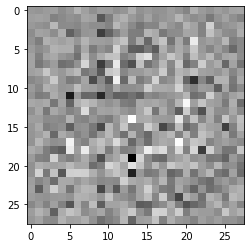

In [5]:
noise = tf.random.normal([1, 100])
test = DCGAN().CreateGenerator()
generated_image = test(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [49]:
GAN = DCGAN()
GAN.Training(TrainImages)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:25<03:50, 25.63s/it]


 20%|██        | 2/10 [00:49<03:20, 25.11s/it]


 30%|███       | 3/10 [01:13<02:53, 24.75s/it]


 40%|████      | 4/10 [01:37<02:26, 24.48s/it]


 50%|█████     | 5/10 [02:01<02:01, 24.30s/it]


 60%|██████    | 6/10 [02:24<01:36, 24.14s/it]


 70%|███████   | 7/10 [02:48<01:12, 24.05s/it]


 80%|████████  | 8/10 [03:12<00:47, 23.99s/it]


 90%|█████████ | 9/10 [03:36<00:23, 23.94s/it]


100%|██████████| 10/10 [04:00<00:00, 24.02s/it]


tf.Tensor([[-1.6243185]], shape=(1, 1), dtype=float32)


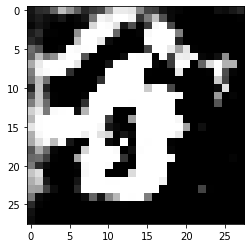

In [57]:
noise = tf.random.normal([1, 100])
generated_image = GAN.Generator(noise, training=False)
prediction = GAN.Discriminator(generated_image)
plt.imshow(generated_image[0, :, :, 0], cmap='gray');
print(prediction)

23400